In [1]:
import pandas as pd
import plotly as py
from plotly import tools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from datetime import datetime
import numpy as np

from scipy import stats
import scipy.optimize
from scipy.optimize import OptimizeWarning
import warnings
import math


import nbimporter
from feature_functions import *

import sklearn
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Importing Jupyter notebook from feature_functions.ipynb


In [2]:
df=pd.read_csv('EURUSD.csv')
df.columns=['date','open','high','low','close','volume']
df.date = pd.to_datetime(df.date,format='%d.%m.%Y %H:%M:%S.%f')
df=df.set_index(df.date)
df=df[['open','high','low','close','volume']]

In [3]:
df = heikenashi(df,[1])
df.columns=['open','high','low','close']

In [4]:
res = momentum(df,[10]).close[10]
df=df.loc[df.index[10]:]
df['momentum'] = res

In [5]:
df['return'] = df['close'] - df['close'].shift(1)

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)



In [6]:
# Make training dataset

n_features = 30 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    
    i = df.index.get_loc(index)
    if i<n_features:
        continue
                
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    #_x= np.append(_x,np.float(df['momentum'][i])) 
    
    _y = df['label'][i]
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])


In [7]:
#Support Vector Classifier (SVC)
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
svm_clf = Pipeline([("scaler",StandardScaler()),("linear_svc",LinearSVC(C=1,loss="hinge",max_iter=10000000)),])

cls = svm_clf
LinearSVC
train_len = int(len(train_x)*0.95)
cls.fit(train_x[:train_len], train_y[:train_len])

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', max_iter=10000000))])

In [8]:
accuracy_train = accuracy_score(train_y[:train_len], cls.predict(train_x[:train_len]))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))


Train Accuracy: 65.27%


In [9]:
pred = cls.predict(train_x[train_len:])

contracts  = 2000.0
commission = 0.0
def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

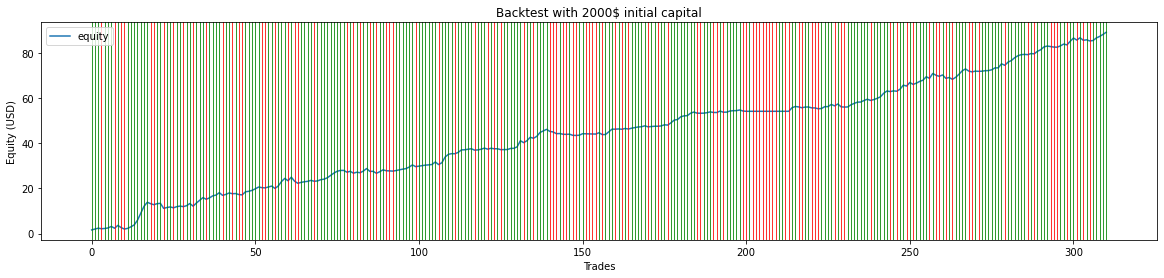

In [10]:
df_trade = pd.DataFrame(np.array(df['return'][train_len+30:]), columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()
df_trade.plot(y='equity', figsize=(20,4), title=f'Backtest with {int(contracts)}$ initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=1, alpha=0.8, color='r')

Net Profit            : $89.15
Number Winning Trades : 202
Number Losing Trades  : 94
Percent Profitable    : 68.24%
Avg Win Trade         : $0.677
Avg Los Trade         : $-0.507
Largest Win Trade     : $3.115
Largest Los Trade     : $-2.225
Profit Factor         : 2.87


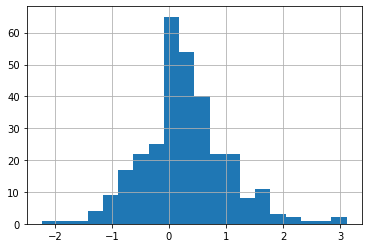

In [11]:
# Calculate summary of trades
n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)